In [1]:
%matplotlib inline
import PIL
import matplotlib.pyplot as plt
import numpy as np
import fitsio
import scipy.interpolate as interpolate

## Evaluating the signal and signal to noise in APOGEE-2S data

Based on the April, May, and June 2017 runs at the du Pont, I have performed the evaluation below on the data of the major factors affecting signal and signal-to-noise in the data. 

Note that a basic takeaway from my analysis is that in the absence of seeing, the typical median counts in the green chip at H=12 would be 370 per pixel. There is scatter around this of 10-15% whose cause is unknown. This number can be used to estimate the throughput of the end-to-end system aside from seeing losses, at least approximately (there may be about 10% additional loss due to offsets of images from the fibers, which would mean increase in the estimate of the throughput of the rest of the system).

Another basic take away is that I can give a pretty decent prediction of what the $(S/N)^2$ of an exposure will be based on the seeing. At 1 arcsec FWHM seeing in the optical we expect for a 500-second exposure, if the guiding is reported as good (~ 0.3 arcsrc guider RMS), $(S/N)^2$ of 450 at H=12 using my metric, or an APOGEE quicklook value of 420 or so. The routine sn2_prediction() near the bottom is a standalone function that will return this expectation.

### Data and method

The list of MJDs I analyze includes most of the data from each run; I chose nights where there were multiple plates observed to avoid very bad weather.

In [2]:
mjds = [57851, 57852, 57855, 57856, 57877, 57878, 57913, 57914, 57915, 57916]

I based my analysis on the quicklook reductions because they were what was available when I began; probably an easier and more accurate way would involve the full reductions. In any case, from the ap1D files and the guider files I calculate:

 * Signal (sky-subtracted) in each fiber
 * Noise in each fiber
 * Median seeing across the exposure
 * Median guideRMS across the exposure
 
Then I fit the log of (S/N)^2 and log of the signal as a function of H-band magnitude (with a fixed power law slope of -0.5 and -0.4 respectively) in the range 11 < H < 12.5, and evaluate each at H=12. The figure below shows one example of this, showing the base-10 logarithm of the median signal in counts in each fiber (in the green chip) versus H-band magnitude (the points are colored by focal radius in mm).

My definition of $(S/N)^2$ is fairly close to that of quicklook, but I can't swear it is exactly the same. It should be effectively slightly (around 10%) higher.


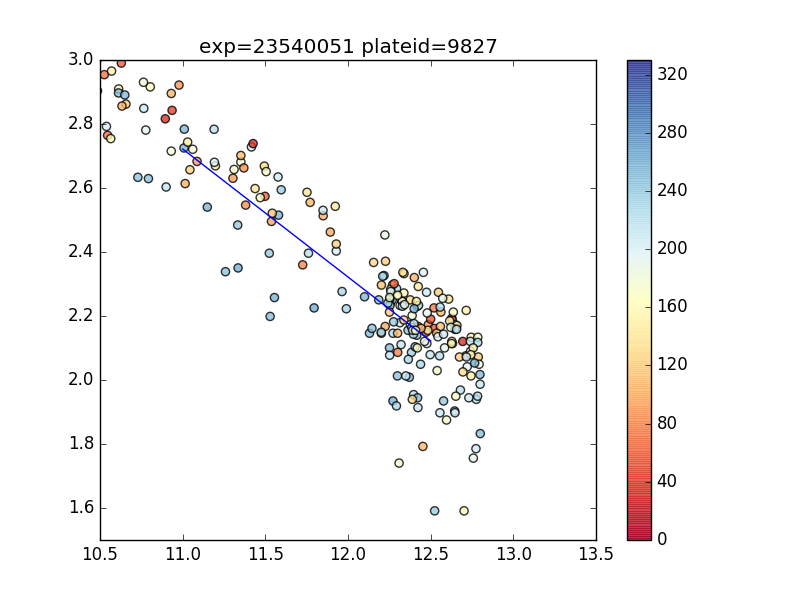

In [3]:
# Example signal vs. H band magnitude for one exposure
PIL.Image.open("exp-sig-23540051.png")

In [4]:
# These files contain the information described above.
all = None
for mjd in mjds:
    tmp_all = fitsio.read("all-{mjd}.fits".format(mjd=mjd))
    if(all is None):
        all = tmp_all
    else:
        all = np.append(all, tmp_all)

In [5]:
plateids = (np.unique(all['plateid']))

### Effect of seeing on signal

Now, in order to interpret the results I first performed a theoretical calculation of how much light gets down a 120 micron fiber on the du Pont under various seeing conditions, as well as when the star image is offset from the fiber center. This is a simplified calculation but as we will see below, sufficient to explain our observations. The formula below is a polynomial fit to the case with zero offset. I plot the light fraction versus optical seeing using the standard dependence of seeing on wavelength.

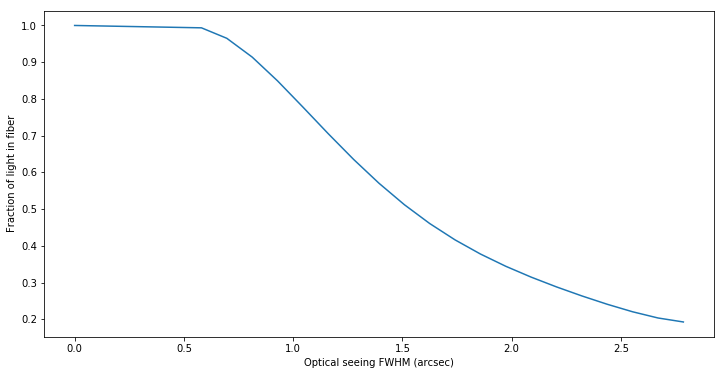

In [6]:
coeffs = np.array([0.16691948, -0.12886663, -0.15449739, 0.30526956, -0.41347824, 0.41610774])
deg = 5
seeings = 0.5 + np.arange(20) * 0.1
smodel = np.zeros(len(seeings))
for indx in np.arange(deg + 1):
    smodel = smodel + coeffs[indx] * (seeings - 1.5)**(deg-indx)
seeings = np.append([0.], seeings)
smodel = np.append([1.], smodel)
oseeings = (16000. / 7600.)**0.2 * seeings
plt.figure(figsize=(12,6))
plt.plot(oseeings, smodel)
plt.xlabel('Optical seeing FWHM (arcsec)')
plt.ylabel('Fraction of light in fiber')

I can use this curve to try to calculate the typical counts per pixel at H=12, accounting for the variation in seeing. 
I find in the calculation below that the typical signal at H=12 is well explained if the curve above is normalized to about 370.

In [7]:
signal_predict = interpolate.interp1d(oseeings, smodel, bounds_error=False)
iok = np.nonzero(all['seeing_median'] == all['seeing_median'])[0]
predicted = signal_predict(all['seeing_median'][iok])
mean_counts_at_12 = (all['sigfit'][iok] * predicted).sum() / (predicted * predicted).sum()
print(mean_counts_at_12)

369.543693015


Using this normalization I overplot the signal as a function of the median seeing per exposure on top of the data. Each color is a different plate. The black curve shows the model scaled to fit the upper envelope of the distribution, and the red curve uses the mean determined immediately above.

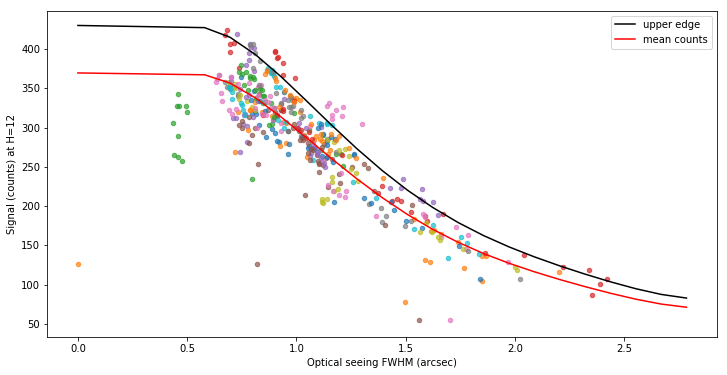

In [8]:
plt.figure(figsize=(12,6))
for plateid in plateids:
    iplate = np.nonzero(all['plateid'] == plateid)[0]
    plt.scatter(all['seeing_median'][iplate], all['sigfit'][iplate], 20, alpha=0.7)
plt.plot(oseeings, 430. * smodel, color='black', label='upper edge')
plt.plot(oseeings, mean_counts_at_12 * smodel, color='red', label='mean counts')
plt.xlabel('Optical seeing FWHM (arcsec)')
plt.ylabel('Signal (counts) at H=12')
plt.legend()

The basic shape of the distribution is well explained by the seeing. Recall that this shape (aside from the overall normalization) was not a fit to the data but a prediction of the fraction of light going down the fiber. On top of this pleasant looking agreement, however, is considerable scatter in signal (20-30%). 

### Effect of guider RMS on signal

What causes the scatter at fixed seeing? We consider possibility of the median guideRMS. This is just the RMS of the guide stars relative to where they should be. Typically, this RMS is roughly constant during the exposure; the guide stars are not moving around.

Note that over most of this data, the guider was running without the refraction balance on, so exposures away from the design hour angle of the plate will show issues. We therefore exclude cases more than 1 hour away, but the result depends little on this choice.

/Users/blanton/anaconda/envs/py3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/blanton/anaconda/envs/py3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


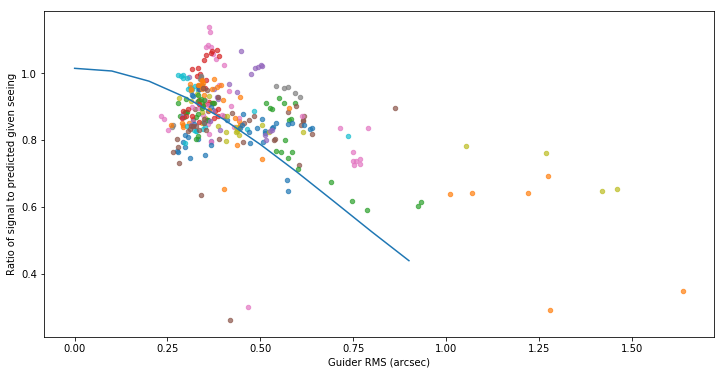

In [9]:
plt.figure(figsize=(12,6))
for plateid in plateids:
    iplate = np.nonzero(all['plateid'] == plateid)[0]
    ratio = all['sigfit'][iplate] / (430. * signal_predict(all['seeing_median'][iplate]))
    ha = all['lst'][iplate] - all['raCen'][iplate]
    hadiff = all['ha_design'][iplate] - ha
    ii = np.nonzero(np.abs(hadiff) < 15.)[0]
    plt.scatter(all['guider_rms_median'][iplate[ii]], ratio[ii], 20, alpha=0.7)

deg = 3
coeffs = np.array([ 0.69342741,  -0.25525592, -0.73221281,  0.48698935])
coeffs = np.array([ 0.27222801, -0.18204834, -0.36626856,  0.35796333])
offsets = np.arange(10) / 10.
model = np.zeros(len(offsets))
for indx in np.arange(deg + 1):
    model = model + coeffs[indx] * (offsets - 0.5)**(deg-indx)
plt.plot(offsets, 2.2 * model)

plt.xlabel('Guider RMS (arcsec)')
plt.ylabel('Ratio of signal to predicted given seeing')

The guider RMS is almost never below about 0.3 arcsec. Theoretically, we would predict that an offset at that level should yield something like a 10% hit in throughput; the blue line is the prediction at 1.4 arcsec seeing. 
We see about that value with 10% scatter around it. In general, the dependence on guider RMS is there, but weaker than one would predict (e.g. at an offset of 1 arcsec, there should be at least a factor of three reduction in flux, even for bad seeing). 

The low signal plate at seeing FWHM of 0.5 arcsec appears related to its bad guider RMS.

In general, it is not very obvious that guider RMS is the best secondary metric for data quality after seeing.

### Effect of seeing on signal-to-noise

We can perform a similar analysis for the signal to noise. Here I utilize the quicklook estimates of the noise; very approximately these yield: $\sigma^2 = S/3 + 100$ in units of counts$^2$, which I also apply to the simple seeing-based model. Again, this describes the observed trend well, with however some considerable scatter of currently unknown origin. 

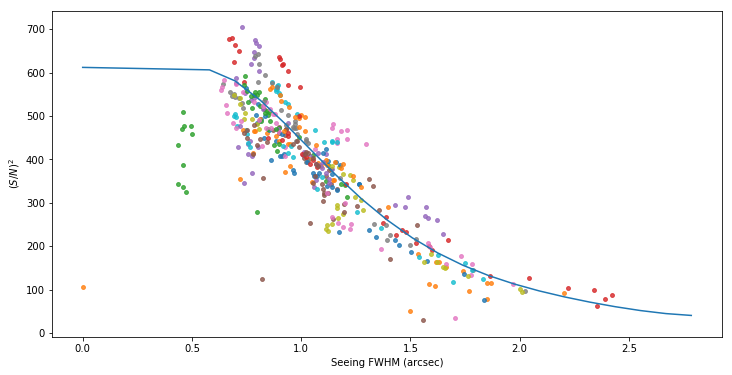

In [10]:
plt.figure(figsize=(12,6))
for plateid in plateids:
    iplate = np.nonzero(all['plateid'] == plateid)[0]
    plt.scatter(all['seeing_median'][iplate], all['snrfit'][iplate], 15, alpha=0.8)
plt.plot(oseeings, (mean_counts_at_12 * smodel)**2 / (mean_counts_at_12 * smodel / 3. + 100))
plt.xlabel('Seeing FWHM (arcsec)')
plt.ylabel('$(S/N)^2$')

In [11]:
def sn2_prediction(seeing=1.):
    """Predict (S/N)^2 based on seeing
    
    Parameters:
    ----------
    
    seeing : np.float32 
        seeing FWHM in optical guider
        
    Returns:
    -------
    
    sn2 : np.float32
        Predicted (S/N)^2 for 500 second APOGEE South exposure
        
    Comments:
    --------
    
    Reported (S/N)^2 is calibrated to that at H=12 based on 
    a fit between H=11 and H=12.5. The Quicklook reported (S/N)^2
    is the median between H=12 and 12.2, and is averages 5-10%
    lower and is likely noisier.
    """
    mean_counts_at_12 = 370.
    coeffs = np.array([0.16691948, -0.12886663, -0.15449739, 0.30526956, -0.41347824, 0.41610774])
    deg = 5
    iseeing = (7600. / 16000.)**0.2 * seeing
    if(iseeing < 0.5):
        smodel = 1.
    else:
        smodel = np.float32(0.)
        for indx in np.arange(deg + 1):
            smodel = smodel + coeffs[indx] * (iseeing - 1.5)**(deg-indx)
    return((mean_counts_at_12 * smodel)**2 / (mean_counts_at_12 * smodel / 3. + 100))

### Comparison of my S/N to APOGEE quicklook's

APOGEE quicklook reports a $(S/N)^2$ based on the median between H=12 and 12.2. It is pretty common that there are only a handful of stars in that range, so this may be noisy. It is also a little fainter than my definition here. If I perform the same comparison I find about a 7\% lower value for the Quicklook definition than mine, which should be kept in mind. 

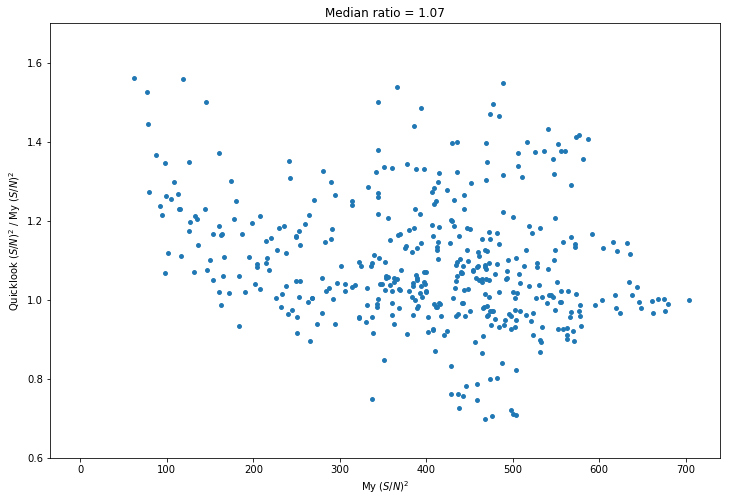

In [12]:
plt.figure(figsize=(12, 8))
plt.scatter(all['snrfit'], all['snrfit'] / all['snr'], 15)
plt.ylim((0.6, 1.7))
plt.xlabel('My $(S/N)^2$')
plt.ylabel('Quicklook $(S/N)^2$ / My $(S/N)^2$')
diff = (np.median(all['snrfit'] / all['snr']))
plt.title('Median ratio = {diff:.2f}'.format(diff=diff))

### Caveats and future work

I have ignored in this analysis the radial variation of the throughput, so we are really only talking about the median across the plate. E.g. this plot shows the offset in dex from the expected signal given the median seeing as a function of focal plane position. Clearly there is a radial term, somewhat quadrupolar in this case. (The blue line is the parallactic angle). It requires a more detailed analysis of the guider images to determine whether these are due to offsets or worse image quality off axis, or both.

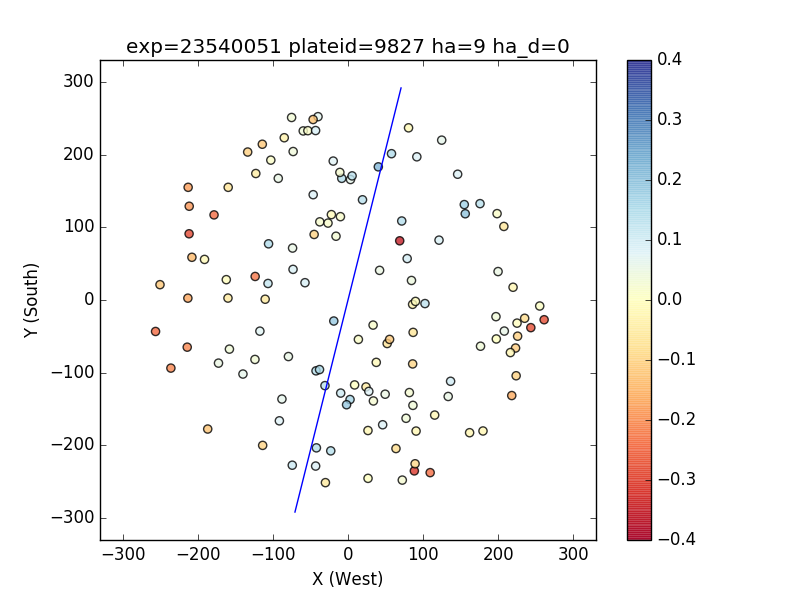

In [13]:
PIL.Image.open("exp-sig-focal-23540051.png")

I have also taken the median seeing and the guider RMS as metrics of quality. I could take a more sophisticated view. E.g. for each guide fiber and each moment calculate its offset and seeing, and calculate the total throughput. This might make it clear whether the guider offsets matter, and make it possible to understand the patterns across the plates. 

Finally, I have not distinguished between bad seeing and collimation problems. They get lumped in together here, and indeed I'm somewhat uncertain how to detangle them; probably it requires a closer analysis of the guider images. They may behave differently in ways that are important to know.